# E-03 카메라 스티커

In [222]:
import matplotlib.pyplot as plt
import numpy as np
import dlib
import math
import cv2
import os
import copy

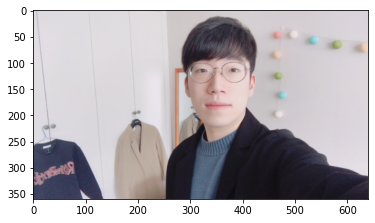

In [223]:
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640, 360))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_dummy = img_bgr.copy()
plt.imshow(img_rgb)
plt.show()

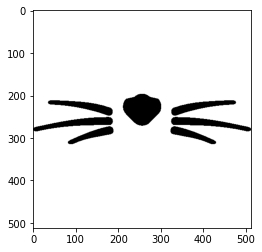

In [224]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)

## 스티커 사진과 적용할 사진 불러오기
### img_bgr  : cv2 read를 하게되면 rgb가 아닌 bgr로 읽어 이러한 변수명을 만듦
### img_rgb : bgr 이미지를 rgb로 바꾼 이미지 dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었다.
### img_dummy : bgr로 받은 원본의 더미
### img_sticker : 스티커 이미지

rectangles[[(270, 64) (425, 219)]]
270 64 425 219


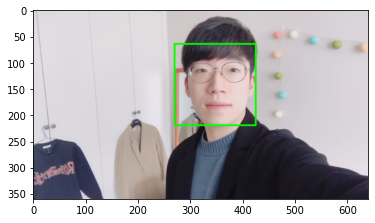

In [225]:
detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_dummy, 1)  #인자로 이미지와 이미지의 얼굴수가 들어간다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(l,t,r,b)

    cv2.rectangle(img_dummy, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_rgb =  cv2.cvtColor(img_dummy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


## detector_hog : dlib에서 제공하는 face detector  
![](https://d3s0tskafalll9.cloudfront.net/media/images/e-8v2-3-1_YFw8FVD.max-800x600.png)
- hog와 svm을 활용한 face detector이고 hog는 원본 이미지에서 색상의 변화량을 가져와 나타낸 것이고,  svm을 통해 벡터를 구분해서 detecting 한다.
- detecting한 얼굴을 dlib_rects로 받아 왼쪽위 좌표와 오른쪽 밑 좌표를 받아 인식한 사각형을 그려 줄 수 있다.

In [226]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [227]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
print(list_landmarks)

68
[[(294, 122), (295, 138), (297, 154), (301, 170), (305, 186), (312, 201), (322, 212), (336, 219), (353, 219), (371, 217), (389, 210), (402, 199), (413, 185), (418, 170), (420, 153), (421, 137), (422, 121), (300, 106), (306, 96), (317, 91), (329, 90), (339, 95), (360, 93), (372, 88), (384, 88), (396, 91), (403, 100), (350, 112), (350, 124), (350, 135), (350, 146), (338, 158), (344, 160), (351, 161), (357, 159), (363, 158), (311, 117), (317, 114), (325, 114), (331, 118), (325, 120), (317, 120), (370, 116), (377, 113), (385, 113), (391, 115), (385, 119), (377, 119), (329, 181), (337, 178), (345, 175), (350, 177), (357, 175), (366, 178), (377, 182), (366, 187), (357, 189), (350, 190), (344, 190), (337, 187), (332, 182), (345, 181), (351, 182), (357, 181), (373, 182), (357, 182), (351, 183), (344, 182)]]


**스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요합니다. 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.**

**Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.**
1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

**저희는  bounding box를 찾았고 내부의 keypoint를 예측해서 사용.**

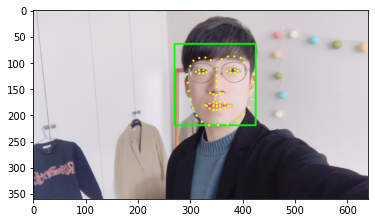

In [228]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_dummy, point, 2, (0, 255, 255), -1)
        
img_rgb = cv2.cvtColor(img_dummy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [229]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] 
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(350, 146)
(x,y) : (350,146)
(w,h) : (156,156)


![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)

## 랜드마크는 이런식으로 맵핑되어있다.
## *변환*을 위해서 39 42 31 35 위치의 점들을 이용하였다.

In [230]:
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
refined_x = x - w //2
refined_y = y  -w //2
print('(x, y): (%d, %d)'%(refined_x, refined_y))
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(156, 156, 3)
(x, y): (272, 68)
(x,y) : (272,68)


### - sticker 이미지를 bounding box의 width로 resize 한다.
### - slicing을 위해 x,y값을 refined해준다.
### - 만약 스티커 이미지가 원본 이미지 크기를 삐져 나온 상황에는 스티커 사진을 slicing한다.


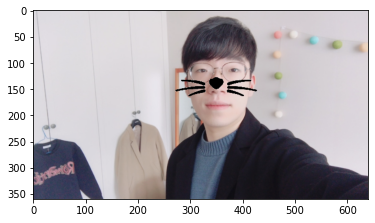

In [231]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) #조건문을 만족하면 stiker_area 아니라면 img_sticker
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))


### -sticker area : img에서 스티커가 들어갈 전체 배경 
### - np.where 함수로 255면(흰색이면) stiker area를 적용하고 아니라면 스티커 이미지를 적용시켜 스티커 이미지를 원본 이미지에 삽입한다.

# 이미지 변환
![](https://i.stack.imgur.com/ARqWb.png)

원근 변환(Perspective Transform) 사용했다.
원근 변환은 이미지를 3차원으로 변환한다고 보시면 됩니다. 멀리 있는 것은 작게 보이고, 가까이 있는 것은 크게 보이는 게 원근법의 원리입니다. 이 원근법의 원리를 적용해 변환하는 방식이 원근 변환입니다. 원근 변환에 필요한 변환 행렬을 반환해주는 함수는 아래와 같습니다.


mtrx = cv2.getPerspectiveTransform(pts1, pts2)
pts1: 변환 이전 영상의 좌표 4개, 4 x 2 배열
pts2: 변환 이후 영상의 좌표 4개, 4 x 2 배열
mtrx: 변환행렬 반환, 3 x 3 행렬

참조 : https://bkshin.tistory.com/entry/OpenCV-14-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%92%A4%ED%8B%80%EA%B8%B0%EC%96%B4%ED%95%80-%EB%B3%80%ED%99%98-%EC%9B%90%EA%B7%BC-%EB%B3%80%ED%99%98

In [212]:
cat_list = [(landmark[39][0] - l, landmark[39][1] - t),
             (landmark[42][0] - l, landmark[42][1] - t),
             (landmark[31][0] - l, landmark[31][1] - t),
             (landmark[35][0] - l, landmark[35][1] - t)] # 랜드마크 좌표
ratio = [(round(i[0] /156,2),round(i[1]/156,2)) for i in cat_list] # 비율만들기
print(ratio)


[(0.39, 0.35), (0.64, 0.33), (0.44, 0.6), (0.6, 0.6)]


# 변환과정
## 1. 기준이 될 랜드마크 설정 :
**39 42 31 35 설정 이유는 얼굴을 돌릴때 코를 기준으로 사각형의 점을 만들어 변환을 하면 얼굴 외각선보다는 낫고 눈은 옆모습일때 애매할 수가 있어 선정하였음**
## 2. 실제 기준이 될 좌표찾기
**스티커 이미지는 bounding box의 크기로 resize되어야하기 때문에 항상 기준 좌표가 바뀐다. 그래서 비율을 찾기 위해 예시이미지로 비율을 찾았다. (156은 resize된 이미지의 크기다)**
## 3. 변환하기 
**비율을 통해 기준점을 만들고 랜드마크 좌표로 변환한다.** 

[(61, 55), (100, 51), (69, 94), (94, 94)]


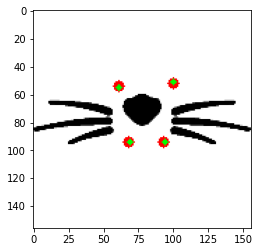

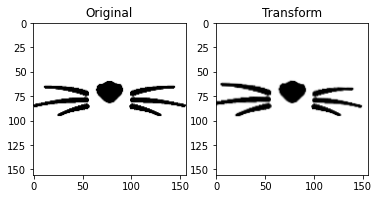

In [213]:
cat_list = [(landmark[39][0] - l, landmark[39][1] - t),
             (landmark[42][0] - l, landmark[42][1] - t),
             (landmark[31][0] - l, landmark[31][1] - t),
             (landmark[35][0] - l, landmark[35][1] - t)]
sticker_copy= img_sticker.copy()
st_dot = [(round(i[0]*w),round(i[1]*w)) for i in ratio]

print(st_dot)

for point in cat_list:
    cv2.circle(sticker_copy, point, 4, (255, 0, 0), -1)
    
for point in st_dot:
    cv2.circle(sticker_copy, point, 2, (0, 255, 0), -1)

plt.imshow(sticker_copy)
plt.show()

# 변환과정
pts1 = np.float32(st_dot) # 이동 전 스티커의 좌표
pts2 = np.float32(cat_list) # 이동 후 스티커의 좌표
mtrx = cv2.getPerspectiveTransform(pts1,pts2) # 변환시켜주는 매트릭스
dst = cv2.warpPerspective(img_sticker,mtrx,(w,h), borderValue = [255, 255, 255, 255]) 
      # 실제로 이미지를 M을 이용해 변환해주는 코드
      # 회전시켰을 때 검은 배경을 없애기 위해 borderValue 설정

plt.subplot(121),plt.imshow(img_sticker),plt.title('Original')
plt.subplot(122),plt.imshow(dst),plt.title('Transform')
plt.show()
    

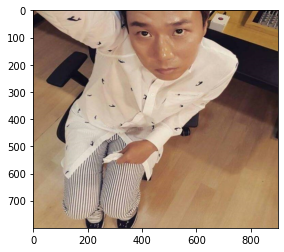

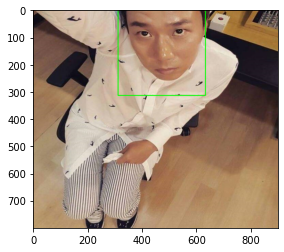

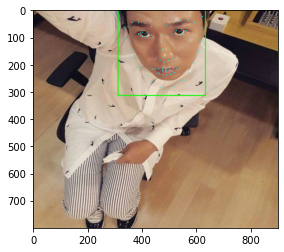

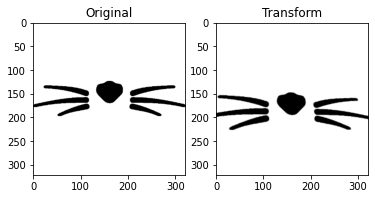

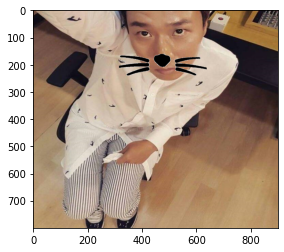

In [239]:
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/lee.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (900, 800))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_dummy = img_bgr.copy()
plt.imshow(img_rgb)
plt.show()
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_rgb, 1)  #인자로 이미지와 이미지의 얼굴수가 들어간다.
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 2, (0, 255, 255), -1)
plt.imshow(img_rgb)
plt.show()


for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] 
    w = h = dlib_rect.width()

img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w //2
refined_y = y - w //2

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
cat_list = [(landmark[39][0] - l, landmark[39][1] - t),
             (landmark[42][0] - l, landmark[42][1] - t),
             (landmark[31][0] - l, landmark[31][1] - t),
             (landmark[35][0] - l, landmark[35][1] - t)]
sticker_copy= img_sticker.copy()
st_dot = [(round(i[0]*w),round(i[1]*w)) for i in ratio]

# 변환과정
pts1 = np.float32(st_dot) # 이동 전 스티커의 좌표
pts2 = np.float32(cat_list) # 이동 후 스티커의 좌표
M = cv2.getPerspectiveTransform(pts1,pts2) # 변환시켜주는 매트릭스
dst = cv2.warpPerspective(img_sticker,M,(w,h), borderValue = [255, 255, 255, 255]) 
      # 실제로 이미지를 M을 이용해 변환해주는 코드
      # 회전시켰을 때 검은 배경을 없애기 위해 borderValue 설정

plt.subplot(121),plt.imshow(img_sticker),plt.title('Original')
plt.subplot(122),plt.imshow(dst),plt.title('Transform')
plt.show()
    
sticker_area = img_bgr[refined_y:refined_y +dst.shape[0],refined_x:refined_x+dst.shape[1]]
img_bgr[refined_y:refined_y +dst.shape[0], refined_x:refined_x+dst.shape[1]] = \
    np.where(dst==255,sticker_area,dst).astype(np.uint8) #조건문을 만족하면 stiker_area 아니라면 img_sticker

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))



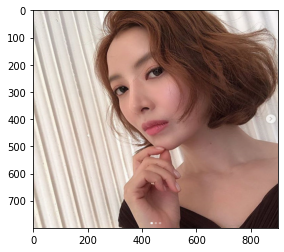

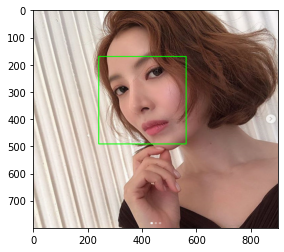

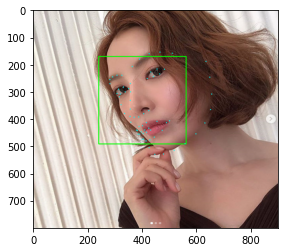

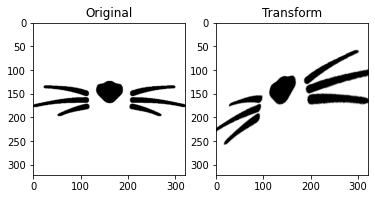

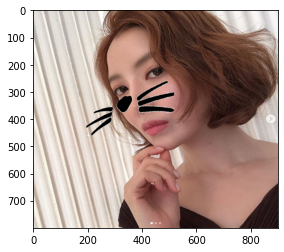

In [240]:
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/yoon.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (900, 800))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_dummy = img_bgr.copy()
plt.imshow(img_rgb)
plt.show()
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_rgb, 1)  #인자로 이미지와 이미지의 얼굴수가 들어간다.
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 2, (0, 255, 255), -1)
plt.imshow(img_rgb)
plt.show()


for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] 
    w = h = dlib_rect.width()

img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w //2
refined_y = y - w //2

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
cat_list = [(landmark[39][0] - l, landmark[39][1] - t),
             (landmark[42][0] - l, landmark[42][1] - t),
             (landmark[31][0] - l, landmark[31][1] - t),
             (landmark[35][0] - l, landmark[35][1] - t)]
sticker_copy= img_sticker.copy()
st_dot = [(round(i[0]*w),round(i[1]*w)) for i in ratio]

# 변환과정
pts1 = np.float32(st_dot) # 이동 전 스티커의 좌표
pts2 = np.float32(cat_list) # 이동 후 스티커의 좌표
M = cv2.getPerspectiveTransform(pts1,pts2) # 변환시켜주는 매트릭스
dst = cv2.warpPerspective(img_sticker,M,(w,h), borderValue = [255, 255, 255, 255]) 
      # 실제로 이미지를 M을 이용해 변환해주는 코드
      # 회전시켰을 때 검은 배경을 없애기 위해 borderValue 설정

plt.subplot(121),plt.imshow(img_sticker),plt.title('Original')
plt.subplot(122),plt.imshow(dst),plt.title('Transform')
plt.show()
    
sticker_area = img_bgr[refined_y:refined_y +dst.shape[0],refined_x:refined_x+dst.shape[1]]
img_bgr[refined_y:refined_y +dst.shape[0], refined_x:refined_x+dst.shape[1]] = \
    np.where(dst==255,sticker_area,dst).astype(np.uint8) #조건문을 만족하면 stiker_area 아니라면 img_sticker

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))



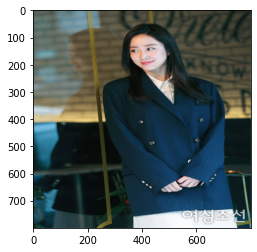

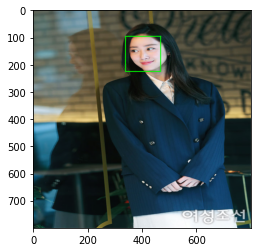

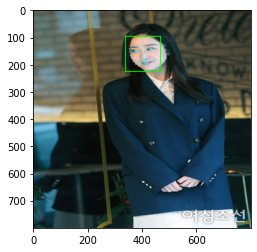

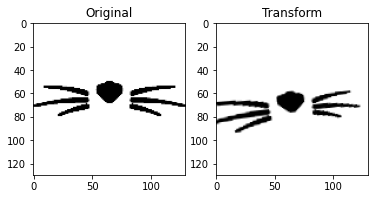

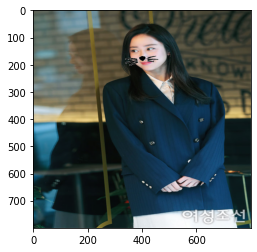

In [242]:
my_image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/img2.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (800, 800))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_dummy = img_bgr.copy()
plt.imshow(img_rgb)
plt.show()
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_rgb, 1)  #인자로 이미지와 이미지의 얼굴수가 들어간다.
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 2, (0, 255, 255), -1)
plt.imshow(img_rgb)
plt.show()


for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] 
    w = h = dlib_rect.width()

img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w //2
refined_y = y - w //2

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
cat_list = [(landmark[39][0] - l, landmark[39][1] - t),
             (landmark[42][0] - l, landmark[42][1] - t),
             (landmark[31][0] - l, landmark[31][1] - t),
             (landmark[35][0] - l, landmark[35][1] - t)]
sticker_copy= img_sticker.copy()
st_dot = [(round(i[0]*w),round(i[1]*w)) for i in ratio]

# 변환과정
pts1 = np.float32(st_dot) # 이동 전 스티커의 좌표
pts2 = np.float32(cat_list) # 이동 후 스티커의 좌표
M = cv2.getPerspectiveTransform(pts1,pts2) # 변환시켜주는 매트릭스
dst = cv2.warpPerspective(img_sticker,M,(w,h), borderValue = [255, 255, 255, 255]) 
      # 실제로 이미지를 M을 이용해 변환해주는 코드
      # 회전시켰을 때 검은 배경을 없애기 위해 borderValue 설정

plt.subplot(121),plt.imshow(img_sticker),plt.title('Original')
plt.subplot(122),plt.imshow(dst),plt.title('Transform')
plt.show()
    
sticker_area = img_bgr[refined_y:refined_y +dst.shape[0],refined_x:refined_x+dst.shape[1]]
img_bgr[refined_y:refined_y +dst.shape[0], refined_x:refined_x+dst.shape[1]] = \
    np.where(dst==255,sticker_area,dst).astype(np.uint8) #조건문을 만족하면 stiker_area 아니라면 img_sticker

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))


- 여러각도의 사진과 얼굴이 먼 이미지를 확인해보았다.
- 어색한 부분이 있지만 그래도 잘 동작하는 모습이다.

# 회고 
### detector_hog : dlib에서 제공하는 face detector
- hog를 통하여 이미지의 벡터 변화량을 얻고, svm으로 학습한 모델을 직접 경험해보아 학습전 전처리의 중요성과 하나의 기법을 잘 배우고.랜드마크 를 이용하는 방법을 알았다.
### 이미지 변환
- nod를 수행하면서 다양한 이미지 변환(아핀,perpective,etc)을 알았고 ,거기에 선형변환의 원리가 깔려있는 것을 알았다. cv에 내장된 함수를 사용은 했지만 정확한 동작원리는 이해하지 못해 더 알아보고싶다.
### 다양한 라이브러리 응용
- 넘파이의 whrere함수와 슬라이싱을 알긴했지만 실제로 사용을 하지 못해 이해도가 떨어졌었는데 이번 실습을 통해 써먹을 방법을 보여줘서 눈이 트인 느낌이다. 또한 cv와 plt의 대한 사용방법도 많이 이해했다.